In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import itertools
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from sklearn.metrics import mean_squared_error

In [2]:
filename="perrin-freres-monthly-champagne.csv"
df=pd.read_csv(filename,index_col="Month",parse_dates=True)
df.columns=["sales"]
df.head()

,sales
Month,
1964-01,2815.0
1964-02,2672.0
1964-03,2755.0
1964-04,2721.0
1964-05,2946.0


In [8]:
df.index=pd.to_datetime(df.index,errors="ignore")
df.index.freq='MS'
print(f"df has {len(df)} records now")
print(f"index frequency is {df.index.freq}")
print(f"index type is {df.index.dtype}")
print(f"first few elements of index : {df.index[:5]}")
print(f"last few elements of index : {df.index[-5:]}")

df has 107 records now
index frequency is MS
index type is object
first few elements of index : Index(['1964-01', '1964-02', '1964-03', '1964-04', '1964-05'], dtype='object', name='Month')
last few elements of index : Index([                                               '1972-07',
                                                      '1972-08',
                                                      '1972-09',
                                                            nan,
       'Perrin Freres monthly champagne sales millions ?64-?72'],
      dtype='object', name='Month')


In [12]:
# because last two elements are not datetime removing them
df = df.loc[df.index[:-2]]
print(df.index[-3:])

Index(['1972-07', '1972-08', '1972-09'], dtype='object', name='Month')


In [26]:
df.index=pd.to_datetime(df.index)
df.index.freq="MS"
print(f"index type is {df.index.dtype} and its frequency is {df.index.freq}")
print(f"df now has length {len(df)}, it starts from {df.index[0]} and ends with {df.index[-1]}")

index type is datetime64[ns] and its frequency is <MonthBegin>
df now has length 105, it starts from 1964-01-01 00:00:00 and ends with 1972-09-01 00:00:00


<AxesSubplot: xlabel='Month'>

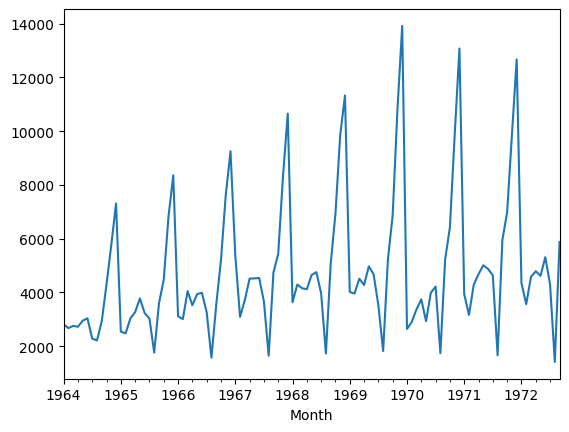

In [15]:
df["sales"].plot()

In [16]:
print(f"df length is {len(df)}")

df length is 105


In [27]:
# Assume the forecast horizon we care about is 12
# Validate over 10 steps
h = 9
steps = 10
Ntest = len(df) - h - steps + 1
print(f"h is {h}, steps is {steps}, Ntest which is the index from which test dataset starts is {Ntest}")

h is 9, steps is 10, Ntest which is the index from which test dataset starts is 87


In [18]:
# configuration hyperparameters to try
trend_type_list = ["add","mul"]
seasonal_type_list = ["add", "mul"]
damped_trend_list = [True, False]
init_method_list = ["estimated","heuristic","legacy-heuristic"]
use_boxcox_list = [True, False, 0]

In [46]:
def walkforward(trend_type, seasonal_type,damped_trend,init_method,use_boxcox,debug=False,col_name="sales"):
    errors=[]
    seen_last = False
    steps_completed = 0

    for end_of_train in range(Ntest,len(df)-h+1):
        if not seen_last:            
            # we don't have to manually add the data to our dataset
            # just index it at the right points - this is a view not a copy
            # so it doesn't take up any extra space or computation
            train = df.iloc[:end_of_train]
            test = df.iloc[end_of_train : end_of_train + h]

            if test.index[-1] == df.index[-1]:
                seen_last = True
            
            steps_completed += 1
            if debug:
                print(f"This is step {steps_completed}")
                print(f"train size : {len(train)}")
                print(f"test size : {len(test)}")
                test_nan_values = test[test["sales"].isnull()]
                print(f"test nan records : {len(test_nan_values)}")
                if len(test_nan_values)>0:
                    print(f"test dataset with null values somewhere : {test}")

            hw = ExponentialSmoothing(train[col_name], initialization_method=init_method, trend=trend_type,damped_trend=damped_trend, seasonal=seasonal_type,seasonal_periods=12,use_boxcox=use_boxcox)
            res_hw = hw.fit()

            # compute error for the forecast horizon
            fcast = res_hw.forecast(h)
            fcast_nan_values = fcast[fcast.isnull()]
            
            if debug:
                print(f"fcast values are {fcast}")
                print(f"test values are {test[col_name]}")
            if len(fcast_nan_values)==0:
                error = mean_squared_error(test[col_name],fcast)
                errors.append(error)
    
    return np.mean(errors)

In [47]:
walkforward("add","add",False,"legacy-heuristic",0,debug=True)

This is step 1
train size : 87
test size : 9
test nan records : 0
fcast values are 1971-04-01     4069.821275
1971-05-01     3908.041783
1971-06-01     4584.265312
1971-07-01     4325.367825
1971-08-01     2086.761042
1971-09-01     5472.278457
1971-10-01     6806.488155
1971-11-01    10205.619590
1971-12-01    13033.979592
Freq: MS, dtype: float64
test values are Month
1971-04-01     4676.0
1971-05-01     5010.0
1971-06-01     4874.0
1971-07-01     4633.0
1971-08-01     1659.0
1971-09-01     5951.0
1971-10-01     6981.0
1971-11-01     9851.0
1971-12-01    12670.0
Freq: MS, Name: sales, dtype: float64
This is step 2
train size : 88
test size : 9
test nan records : 0
fcast values are 1971-05-01     4012.166426
1971-06-01     4689.491240
1971-07-01     4427.542067
1971-08-01     2189.600878
1971-09-01     5573.865648
1971-10-01     6907.242416
1971-11-01    10302.304843
1971-12-01    13120.013527
1972-01-01     3734.882591
Freq: MS, dtype: float64
test values are Month
1971-05-01     501

171133.46915800744

In [44]:
# iterate through all possible options
tuple_of_option_lists = (trend_type_list,seasonal_type_list,damped_trend_list,init_method_list,use_boxcox_list)

In [40]:
%pdb

Automatic pdb calling has been turned ON


In [48]:
best_score = float("inf")
best_options = None

for x in itertools.product(*tuple_of_option_lists):
    print(f"trying walk forward for options : {x}")    
    score = walkforward(*x,debug=False)

    if score < best_score:
        best_score = score
        best_options = x
        print(f"best score so far : {best_score}, with options : {best_options}")


trying walk forward for options : ('add', 'add', True, 'estimated', True)
best score so far : 307849.41072380566, with options : ('add', 'add', True, 'estimated', True)
trying walk forward for options : ('add', 'add', True, 'estimated', False)


c:\Users\amrul\programming\python_environments\dlenv_py39\lib\site-packages\statsmodels\tsa\holtwinters\model.py:917: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
c:\Users\amrul\programming\python_environments\dlenv_py39\lib\site-packages\statsmodels\tsa\holtwinters\model.py:917: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
c:\Users\amrul\programming\python_environments\dlenv_py39\lib\site-packages\statsmodels\tsa\holtwinters\model.py:917: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
c:\Users\amrul\programming\python_environments\dlenv_py39\lib\site-packages\statsmodels\tsa\holtwinters\model.py:917: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
c:\Users\amrul\programming\python_environments\dlenv_py39\lib\site-packages\statsmodels\tsa\holtwinters\model.py:917: ConvergenceWarning: Optimization failed to converge. C

best score so far : 192986.50545571145, with options : ('add', 'add', True, 'estimated', False)
trying walk forward for options : ('add', 'add', True, 'estimated', 0)
trying walk forward for options : ('add', 'add', True, 'heuristic', True)
trying walk forward for options : ('add', 'add', True, 'heuristic', False)


c:\Users\amrul\programming\python_environments\dlenv_py39\lib\site-packages\statsmodels\tsa\holtwinters\model.py:917: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
c:\Users\amrul\programming\python_environments\dlenv_py39\lib\site-packages\statsmodels\tsa\holtwinters\model.py:917: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
c:\Users\amrul\programming\python_environments\dlenv_py39\lib\site-packages\statsmodels\tsa\holtwinters\model.py:917: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
c:\Users\amrul\programming\python_environments\dlenv_py39\lib\site-packages\statsmodels\tsa\holtwinters\model.py:917: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
c:\Users\amrul\programming\python_environments\dlenv_py39\lib\site-packages\statsmodels\tsa\holtwinters\model.py:917: ConvergenceWarning: Optimization failed to converge. C

trying walk forward for options : ('add', 'add', True, 'heuristic', 0)
trying walk forward for options : ('add', 'add', True, 'legacy-heuristic', True)
trying walk forward for options : ('add', 'add', True, 'legacy-heuristic', False)


c:\Users\amrul\programming\python_environments\dlenv_py39\lib\site-packages\statsmodels\tsa\holtwinters\model.py:917: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
c:\Users\amrul\programming\python_environments\dlenv_py39\lib\site-packages\statsmodels\tsa\holtwinters\model.py:917: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
c:\Users\amrul\programming\python_environments\dlenv_py39\lib\site-packages\statsmodels\tsa\holtwinters\model.py:917: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
c:\Users\amrul\programming\python_environments\dlenv_py39\lib\site-packages\statsmodels\tsa\holtwinters\model.py:917: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
c:\Users\amrul\programming\python_environments\dlenv_py39\lib\site-packages\statsmodels\tsa\holtwinters\model.py:917: ConvergenceWarning: Optimization failed to converge. C

trying walk forward for options : ('add', 'add', True, 'legacy-heuristic', 0)
best score so far : 169097.59391452145, with options : ('add', 'add', True, 'legacy-heuristic', 0)
trying walk forward for options : ('add', 'add', False, 'estimated', True)
trying walk forward for options : ('add', 'add', False, 'estimated', False)
trying walk forward for options : ('add', 'add', False, 'estimated', 0)
trying walk forward for options : ('add', 'add', False, 'heuristic', True)
trying walk forward for options : ('add', 'add', False, 'heuristic', False)
trying walk forward for options : ('add', 'add', False, 'heuristic', 0)
trying walk forward for options : ('add', 'add', False, 'legacy-heuristic', True)
trying walk forward for options : ('add', 'add', False, 'legacy-heuristic', False)
trying walk forward for options : ('add', 'add', False, 'legacy-heuristic', 0)
trying walk forward for options : ('add', 'mul', True, 'estimated', True)
trying walk forward for options : ('add', 'mul', True, 'est

c:\Users\amrul\programming\python_environments\dlenv_py39\lib\site-packages\statsmodels\tsa\holtwinters\model.py:917: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
c:\Users\amrul\programming\python_environments\dlenv_py39\lib\site-packages\statsmodels\tsa\holtwinters\model.py:917: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
c:\Users\amrul\programming\python_environments\dlenv_py39\lib\site-packages\statsmodels\tsa\holtwinters\model.py:917: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
c:\Users\amrul\programming\python_environments\dlenv_py39\lib\site-packages\statsmodels\tsa\holtwinters\model.py:917: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
c:\Users\amrul\programming\python_environments\dlenv_py39\lib\site-packages\statsmodels\tsa\holtwinters\model.py:917: ConvergenceWarning: Optimization failed to converge. C

trying walk forward for options : ('add', 'mul', True, 'estimated', 0)
trying walk forward for options : ('add', 'mul', True, 'heuristic', True)
trying walk forward for options : ('add', 'mul', True, 'heuristic', False)


c:\Users\amrul\programming\python_environments\dlenv_py39\lib\site-packages\statsmodels\tsa\holtwinters\model.py:917: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
c:\Users\amrul\programming\python_environments\dlenv_py39\lib\site-packages\statsmodels\tsa\holtwinters\model.py:917: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
c:\Users\amrul\programming\python_environments\dlenv_py39\lib\site-packages\statsmodels\tsa\holtwinters\model.py:917: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
c:\Users\amrul\programming\python_environments\dlenv_py39\lib\site-packages\statsmodels\tsa\holtwinters\model.py:917: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
c:\Users\amrul\programming\python_environments\dlenv_py39\lib\site-packages\statsmodels\tsa\holtwinters\model.py:917: ConvergenceWarning: Optimization failed to converge. C

trying walk forward for options : ('add', 'mul', True, 'heuristic', 0)
trying walk forward for options : ('add', 'mul', True, 'legacy-heuristic', True)
trying walk forward for options : ('add', 'mul', True, 'legacy-heuristic', False)


c:\Users\amrul\programming\python_environments\dlenv_py39\lib\site-packages\statsmodels\tsa\holtwinters\model.py:917: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
c:\Users\amrul\programming\python_environments\dlenv_py39\lib\site-packages\statsmodels\tsa\holtwinters\model.py:917: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
c:\Users\amrul\programming\python_environments\dlenv_py39\lib\site-packages\statsmodels\tsa\holtwinters\model.py:917: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
c:\Users\amrul\programming\python_environments\dlenv_py39\lib\site-packages\statsmodels\tsa\holtwinters\model.py:917: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
c:\Users\amrul\programming\python_environments\dlenv_py39\lib\site-packages\statsmodels\tsa\holtwinters\model.py:917: ConvergenceWarning: Optimization failed to converge. C

trying walk forward for options : ('add', 'mul', True, 'legacy-heuristic', 0)
trying walk forward for options : ('add', 'mul', False, 'estimated', True)
trying walk forward for options : ('add', 'mul', False, 'estimated', False)
trying walk forward for options : ('add', 'mul', False, 'estimated', 0)
trying walk forward for options : ('add', 'mul', False, 'heuristic', True)
trying walk forward for options : ('add', 'mul', False, 'heuristic', False)
trying walk forward for options : ('add', 'mul', False, 'heuristic', 0)
trying walk forward for options : ('add', 'mul', False, 'legacy-heuristic', True)
trying walk forward for options : ('add', 'mul', False, 'legacy-heuristic', False)
trying walk forward for options : ('add', 'mul', False, 'legacy-heuristic', 0)
trying walk forward for options : ('mul', 'add', True, 'estimated', True)


c:\Users\amrul\programming\python_environments\dlenv_py39\lib\site-packages\statsmodels\tsa\holtwinters\model.py:83: RuntimeWarning: overflow encountered in matmul
  return err.T @ err
c:\Users\amrul\programming\python_environments\dlenv_py39\lib\site-packages\statsmodels\tsa\holtwinters\model.py:83: RuntimeWarning: overflow encountered in matmul
  return err.T @ err
c:\Users\amrul\programming\python_environments\dlenv_py39\lib\site-packages\statsmodels\tsa\holtwinters\model.py:83: RuntimeWarning: overflow encountered in matmul
  return err.T @ err
c:\Users\amrul\programming\python_environments\dlenv_py39\lib\site-packages\statsmodels\tsa\holtwinters\model.py:83: RuntimeWarning: overflow encountered in matmul
  return err.T @ err
c:\Users\amrul\programming\python_environments\dlenv_py39\lib\site-packages\statsmodels\tsa\holtwinters\model.py:83: RuntimeWarning: overflow encountered in matmul
  return err.T @ err
c:\Users\amrul\programming\python_environments\dlenv_py39\lib\site-packages

trying walk forward for options : ('mul', 'add', True, 'estimated', False)


c:\Users\amrul\programming\python_environments\dlenv_py39\lib\site-packages\statsmodels\tsa\holtwinters\model.py:917: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
c:\Users\amrul\programming\python_environments\dlenv_py39\lib\site-packages\statsmodels\tsa\holtwinters\model.py:917: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
c:\Users\amrul\programming\python_environments\dlenv_py39\lib\site-packages\statsmodels\tsa\holtwinters\model.py:83: RuntimeWarning: overflow encountered in matmul
  return err.T @ err
c:\Users\amrul\programming\python_environments\dlenv_py39\lib\site-packages\statsmodels\tsa\holtwinters\model.py:917: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
c:\Users\amrul\programming\python_environments\dlenv_py39\lib\site-packages\statsmodels\tsa\holtwinters\model.py:83: RuntimeWarning: overflow encountered in matmul
  return err.T @ err
c:\Users\

trying walk forward for options : ('mul', 'add', True, 'estimated', 0)


c:\Users\amrul\programming\python_environments\dlenv_py39\lib\site-packages\statsmodels\tsa\holtwinters\model.py:83: RuntimeWarning: overflow encountered in matmul
  return err.T @ err
c:\Users\amrul\programming\python_environments\dlenv_py39\lib\site-packages\statsmodels\tsa\holtwinters\model.py:83: RuntimeWarning: overflow encountered in matmul
  return err.T @ err
c:\Users\amrul\programming\python_environments\dlenv_py39\lib\site-packages\statsmodels\tsa\holtwinters\model.py:83: RuntimeWarning: overflow encountered in matmul
  return err.T @ err
c:\Users\amrul\programming\python_environments\dlenv_py39\lib\site-packages\statsmodels\tsa\holtwinters\model.py:83: RuntimeWarning: overflow encountered in matmul
  return err.T @ err
c:\Users\amrul\programming\python_environments\dlenv_py39\lib\site-packages\statsmodels\tsa\holtwinters\model.py:83: RuntimeWarning: overflow encountered in matmul
  return err.T @ err
c:\Users\amrul\programming\python_environments\dlenv_py39\lib\site-packages

trying walk forward for options : ('mul', 'add', True, 'heuristic', True)


c:\Users\amrul\programming\python_environments\dlenv_py39\lib\site-packages\numpy\core\fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\amrul\programming\python_environments\dlenv_py39\lib\site-packages\numpy\core\_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


trying walk forward for options : ('mul', 'add', True, 'heuristic', False)


c:\Users\amrul\programming\python_environments\dlenv_py39\lib\site-packages\statsmodels\tsa\holtwinters\model.py:917: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
c:\Users\amrul\programming\python_environments\dlenv_py39\lib\site-packages\statsmodels\tsa\holtwinters\model.py:917: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
c:\Users\amrul\programming\python_environments\dlenv_py39\lib\site-packages\statsmodels\tsa\holtwinters\model.py:917: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
c:\Users\amrul\programming\python_environments\dlenv_py39\lib\site-packages\statsmodels\tsa\holtwinters\model.py:917: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
c:\Users\amrul\programming\python_environments\dlenv_py39\lib\site-packages\statsmodels\tsa\holtwinters\model.py:917: ConvergenceWarning: Optimization failed to converge. C

trying walk forward for options : ('mul', 'add', True, 'heuristic', 0)
trying walk forward for options : ('mul', 'add', True, 'legacy-heuristic', True)
trying walk forward for options : ('mul', 'add', True, 'legacy-heuristic', False)


c:\Users\amrul\programming\python_environments\dlenv_py39\lib\site-packages\statsmodels\tsa\holtwinters\model.py:917: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
c:\Users\amrul\programming\python_environments\dlenv_py39\lib\site-packages\statsmodels\tsa\holtwinters\model.py:917: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
c:\Users\amrul\programming\python_environments\dlenv_py39\lib\site-packages\statsmodels\tsa\holtwinters\model.py:917: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
c:\Users\amrul\programming\python_environments\dlenv_py39\lib\site-packages\statsmodels\tsa\holtwinters\model.py:917: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
c:\Users\amrul\programming\python_environments\dlenv_py39\lib\site-packages\statsmodels\tsa\holtwinters\model.py:917: ConvergenceWarning: Optimization failed to converge. C

trying walk forward for options : ('mul', 'add', True, 'legacy-heuristic', 0)
best score so far : 154725.73997084075, with options : ('mul', 'add', True, 'legacy-heuristic', 0)
trying walk forward for options : ('mul', 'add', False, 'estimated', True)
trying walk forward for options : ('mul', 'add', False, 'estimated', False)


c:\Users\amrul\programming\python_environments\dlenv_py39\lib\site-packages\statsmodels\tsa\holtwinters\model.py:917: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
c:\Users\amrul\programming\python_environments\dlenv_py39\lib\site-packages\statsmodels\tsa\holtwinters\model.py:917: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
c:\Users\amrul\programming\python_environments\dlenv_py39\lib\site-packages\statsmodels\tsa\holtwinters\model.py:917: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
c:\Users\amrul\programming\python_environments\dlenv_py39\lib\site-packages\statsmodels\tsa\holtwinters\model.py:917: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
c:\Users\amrul\programming\python_environments\dlenv_py39\lib\site-packages\statsmodels\tsa\holtwinters\model.py:917: ConvergenceWarning: Optimization failed to converge. C

trying walk forward for options : ('mul', 'add', False, 'estimated', 0)
trying walk forward for options : ('mul', 'add', False, 'heuristic', True)
trying walk forward for options : ('mul', 'add', False, 'heuristic', False)
trying walk forward for options : ('mul', 'add', False, 'heuristic', 0)
trying walk forward for options : ('mul', 'add', False, 'legacy-heuristic', True)
trying walk forward for options : ('mul', 'add', False, 'legacy-heuristic', False)
trying walk forward for options : ('mul', 'add', False, 'legacy-heuristic', 0)
trying walk forward for options : ('mul', 'mul', True, 'estimated', True)
trying walk forward for options : ('mul', 'mul', True, 'estimated', False)


c:\Users\amrul\programming\python_environments\dlenv_py39\lib\site-packages\statsmodels\tsa\holtwinters\model.py:917: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
c:\Users\amrul\programming\python_environments\dlenv_py39\lib\site-packages\statsmodels\tsa\holtwinters\model.py:83: RuntimeWarning: overflow encountered in matmul
  return err.T @ err
c:\Users\amrul\programming\python_environments\dlenv_py39\lib\site-packages\statsmodels\tsa\holtwinters\model.py:917: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
c:\Users\amrul\programming\python_environments\dlenv_py39\lib\site-packages\statsmodels\tsa\holtwinters\model.py:917: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
c:\Users\amrul\programming\python_environments\dlenv_py39\lib\site-packages\statsmodels\tsa\holtwinters\model.py:917: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  wa

trying walk forward for options : ('mul', 'mul', True, 'estimated', 0)
trying walk forward for options : ('mul', 'mul', True, 'heuristic', True)
trying walk forward for options : ('mul', 'mul', True, 'heuristic', False)


c:\Users\amrul\programming\python_environments\dlenv_py39\lib\site-packages\statsmodels\tsa\holtwinters\model.py:917: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
c:\Users\amrul\programming\python_environments\dlenv_py39\lib\site-packages\statsmodels\tsa\holtwinters\model.py:917: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
c:\Users\amrul\programming\python_environments\dlenv_py39\lib\site-packages\statsmodels\tsa\holtwinters\model.py:917: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
c:\Users\amrul\programming\python_environments\dlenv_py39\lib\site-packages\statsmodels\tsa\holtwinters\model.py:917: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
c:\Users\amrul\programming\python_environments\dlenv_py39\lib\site-packages\statsmodels\tsa\holtwinters\model.py:917: ConvergenceWarning: Optimization failed to converge. C

trying walk forward for options : ('mul', 'mul', True, 'heuristic', 0)
trying walk forward for options : ('mul', 'mul', True, 'legacy-heuristic', True)
trying walk forward for options : ('mul', 'mul', True, 'legacy-heuristic', False)


c:\Users\amrul\programming\python_environments\dlenv_py39\lib\site-packages\statsmodels\tsa\holtwinters\model.py:917: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
c:\Users\amrul\programming\python_environments\dlenv_py39\lib\site-packages\statsmodels\tsa\holtwinters\model.py:917: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
c:\Users\amrul\programming\python_environments\dlenv_py39\lib\site-packages\statsmodels\tsa\holtwinters\model.py:917: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
c:\Users\amrul\programming\python_environments\dlenv_py39\lib\site-packages\statsmodels\tsa\holtwinters\model.py:917: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
c:\Users\amrul\programming\python_environments\dlenv_py39\lib\site-packages\statsmodels\tsa\holtwinters\model.py:917: ConvergenceWarning: Optimization failed to converge. C

trying walk forward for options : ('mul', 'mul', True, 'legacy-heuristic', 0)
trying walk forward for options : ('mul', 'mul', False, 'estimated', True)
trying walk forward for options : ('mul', 'mul', False, 'estimated', False)


c:\Users\amrul\programming\python_environments\dlenv_py39\lib\site-packages\statsmodels\tsa\holtwinters\model.py:83: RuntimeWarning: overflow encountered in matmul
  return err.T @ err
c:\Users\amrul\programming\python_environments\dlenv_py39\lib\site-packages\statsmodels\tsa\holtwinters\model.py:917: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
c:\Users\amrul\programming\python_environments\dlenv_py39\lib\site-packages\statsmodels\tsa\holtwinters\model.py:83: RuntimeWarning: overflow encountered in matmul
  return err.T @ err
c:\Users\amrul\programming\python_environments\dlenv_py39\lib\site-packages\statsmodels\tsa\holtwinters\model.py:917: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
c:\Users\amrul\programming\python_environments\dlenv_py39\lib\site-packages\statsmodels\tsa\holtwinters\model.py:83: RuntimeWarning: overflow encountered in matmul
  return err.T @ err
c:\Users\amrul\programming\pyth

trying walk forward for options : ('mul', 'mul', False, 'estimated', 0)


c:\Users\amrul\programming\python_environments\dlenv_py39\lib\site-packages\statsmodels\tsa\holtwinters\model.py:83: RuntimeWarning: overflow encountered in matmul
  return err.T @ err
c:\Users\amrul\programming\python_environments\dlenv_py39\lib\site-packages\statsmodels\tsa\holtwinters\model.py:83: RuntimeWarning: overflow encountered in matmul
  return err.T @ err
c:\Users\amrul\programming\python_environments\dlenv_py39\lib\site-packages\statsmodels\tsa\holtwinters\model.py:83: RuntimeWarning: overflow encountered in matmul
  return err.T @ err
c:\Users\amrul\programming\python_environments\dlenv_py39\lib\site-packages\statsmodels\tsa\holtwinters\model.py:83: RuntimeWarning: overflow encountered in matmul
  return err.T @ err
c:\Users\amrul\programming\python_environments\dlenv_py39\lib\site-packages\statsmodels\tsa\holtwinters\model.py:83: RuntimeWarning: overflow encountered in matmul
  return err.T @ err
c:\Users\amrul\programming\python_environments\dlenv_py39\lib\site-packages

trying walk forward for options : ('mul', 'mul', False, 'heuristic', True)
trying walk forward for options : ('mul', 'mul', False, 'heuristic', False)
trying walk forward for options : ('mul', 'mul', False, 'heuristic', 0)
trying walk forward for options : ('mul', 'mul', False, 'legacy-heuristic', True)
trying walk forward for options : ('mul', 'mul', False, 'legacy-heuristic', False)
trying walk forward for options : ('mul', 'mul', False, 'legacy-heuristic', 0)


In [49]:
print(f"best score is {best_score}")
trend_type,seasonal_type,damped_trend,init_method,use_boxcox=best_options
print(f"trend type : {trend_type}")
print(f"seasonal type : {seasonal_type}")
print(f"damped_trend : {damped_trend}")
print(f"initialization_method : {init_method}")
print(f"use boxcox : {use_boxcox}")

best score is 154725.73997084075
trend type : mul
seasonal type : add
damped_trend : True
initialization_method : legacy-heuristic
use boxcox : 0


In [59]:
test_size=12
train = df.iloc[:-test_size]
test = df.iloc[-test_size:]

hw = ExponentialSmoothing(train["sales"], initialization_method="legacy-heuristic", trend="add",seasonal="add",seasonal_periods=12)
res_hw = hw.fit()

In [60]:
train_idx=df.index<=train.index[-1]
test_idx=df.index>=test.index[0]
df.loc[train_idx,"hw"]=res_hw.fittedvalues
df.loc[test_idx,"hw_test"]=res_hw.forecast(test_size)

<AxesSubplot: xlabel='Month'>

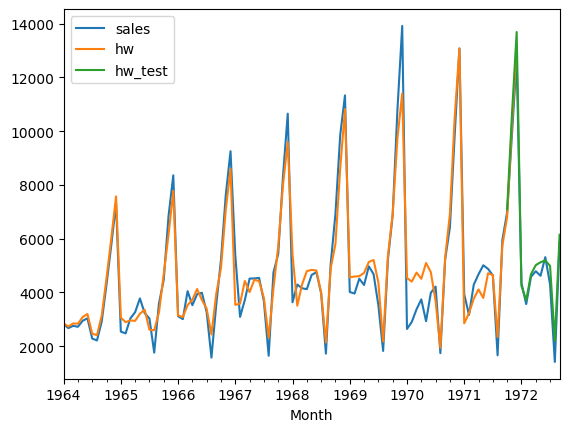

In [61]:
df.plot()

In [63]:
from sklearn.metrics import r2_score

print("train r2 score",r2_score(train["sales"],df.loc[train_idx,"hw"]))
print(f"test r2 score : {r2_score(test['sales'],df.loc[test_idx,'hw_test'])}")

train r2 score 0.9169984903500262
test r2 score : 0.9680340910154467
